In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("mutationc.csv")

In [33]:
def compute_confusion_table(group):
    # actual_1d = pandas series of C's as 1 NC's as 0
    actual_1d = group.iloc[:,0].replace(r'^C\d+$','1',regex=True).replace(r'^NC\d+$','0',regex=True).astype(int)
    # predicted = df containing presence of each column not including col of samples
    predicted = group.iloc[:,1:]
    # convert actual_1d to column vector, tile list to span all of the predicted values
    actual = pd.DataFrame(np.tile(actual_1d.values.reshape(actual_1d.shape[0],1), predicted.shape[1]), columns=predicted.columns, index=predicted.index)
    # calculate TP FP FN TN
    TP = ((actual == 1) & (predicted == 1)).sum(axis=0)
    FP = ((actual == 0) & (predicted == 1)).sum(axis=0)
    FN = ((actual == 1) & (predicted == 0)).sum(axis=0)
    TN = ((actual == 0) & (predicted == 0)).sum(axis=0)
    return pd.DataFrame({"TP":TP,"FP":FP,"FN":FN,"TN":TN,"TP-FP":(TP-FP)})

## Part I : Compute the accuracy for each feature

In [34]:
ct = compute_confusion_table(data)
Accuracy = ( ct.TP+ct.TN / (ct.TP+ct.TN+ct.FP+ct.FN) * 100 )
Accuracy.sort_values(ascending=False).head(10)

BRAF_GRCh37_7:140453136-140453136_Missense-Mutation_SNP_A-A-T               73.771144
DRD5_GRCh37_4:9785349-9785349_3'UTR_SNP_G-G-C                               70.283582
KRAS_GRCh37_12:25398284-25398284_Missense-Mutation_SNP_C-C-A_C-C-T_C-C-G    64.800995
ZBTB20_GRCh37_3:114058003-114058003_Frame-Shift-Del_DEL_G-G--               60.263682
DRD5_GRCh37_4:9785421-9785421_3'UTR_SNP_G-G-T                               59.268657
DOCK3_GRCh37_3:51417604-51417604_Frame-Shift-Del_DEL_C-C--                  58.263682
KRAS_GRCh37_12:25398281-25398281_Missense-Mutation_SNP_C-C-T                57.268657
RNF43_GRCh37_17:56435161-56435161_Frame-Shift-Del_DEL_C-C--                 55.273632
PGM5_GRCh37_9:70993145-70993145_Missense-Mutation_SNP_A-A-G                 55.263682
RAB28_GRCh37_4:13485808-13485808_5'UTR_DEL_G-G--                            55.258706
dtype: float64

## Part II : Calculate Other Metrics

### Classification

In [35]:
# find top TP-FP feature define as F
F = ct.sort_values(by='TP-FP',ascending=False).head(1).index[0]

# derive group A and group B
group_A = data[(data[F] == 1)]
group_B = data[(data[F] == 0)]

# get TP FP values for group A and group B
gA_confusion_table = compute_confusion_table(group_A)
gB_confusion_table = compute_confusion_table(group_B)

# derive alpha and beta features
alpha = gA_confusion_table.sort_values(by='TP-FP',ascending=False).index[1]
beta = gB_confusion_table.sort_values(by='TP-FP',ascending=False).index[0]

In [36]:
# classifying step
def classify(sample):
    if sample[F] == 1:
        return 1 if sample[alpha] == 1 else 0
    else:
        return 1 if sample[beta] == 1 else 0
    
data['classification'] = data.apply(classify, axis=1)

### Derive Metrics

In [37]:
# derive predicted values from classifications like before
actual = data.iloc[:,0].replace(r'^C\d+$','1',regex=True).replace(r'^NC\d+$','0',regex=True).astype(int)
predicted = data.classification
TP = ((actual == 1) & (predicted == 1)).sum(axis=0)
FP = ((actual == 0) & (predicted == 1)).sum(axis=0)
FN = ((actual == 1) & (predicted == 0)).sum(axis=0)
TN = ((actual == 0) & (predicted == 0)).sum(axis=0)
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
Precision = TP / (TP + FP)
Miss_rate = FN / (TP + FN)
False_discovery_rate = FP / (TP + FP)
False_omission_rate = FN / (FN + TN)

Text(50.72222222222221, 0.5, 'ACTUAL')

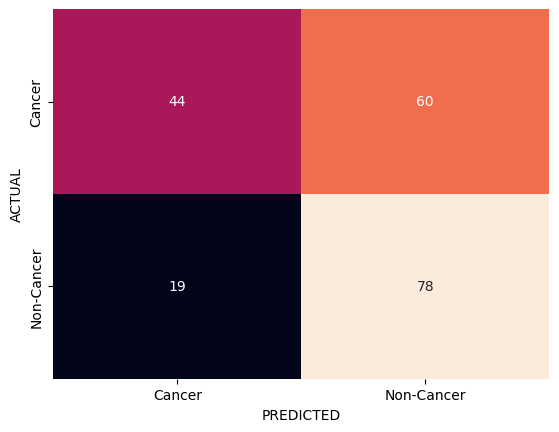

In [38]:
## render confusion matrix
confusion_matrix = pd.DataFrame(columns=["PP","PN"])
confusion_matrix["PP"] = TP, FP
confusion_matrix["PN"] = FN, TN
sns.heatmap(confusion_matrix, annot=True, cbar=False, xticklabels=['Cancer','Non-Cancer'] ,yticklabels=['Cancer','Non-Cancer'], fmt='g')
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")

In [39]:
# print
print(f"TP:{TP} FP:{FP} FN:{FN} TN:{TN}")
print(f"Accuracy: {Accuracy*100:.2f} %")
print(f"Sensitivity: {Sensitivity*100:.2f} %")
print(f"Specificity: {Specificity*100:.2f} %")
print(f"Precision: {Precision*100:.2f} %")
print(f"Miss rate: {Miss_rate*100:.2f} %")
print(f"False discovery_rate: {False_discovery_rate*100:.2f} %")
print(f"False omission rate: {False_omission_rate*100:.2f} %")

TP:44 FP:19 FN:60 TN:78
Accuracy: 60.70 %
Sensitivity: 42.31 %
Specificity: 80.41 %
Precision: 69.84 %
Miss rate: 57.69 %
False discovery_rate: 30.16 %
False omission rate: 43.48 %
